In [2]:
import json
import logging
import os
import re
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.figure import Figure
from matplotlib.patches import Patch

import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()],
)
logger = logging.getLogger("visualize_results")

def load_summary(summary_path, name):
    summaries = {}
    with open(summary_path, "r") as f:
        summary_data = json.load(f)

    # Check if summary has required fields
    if "dataset_scores" not in summary_data:
        logger.warning(f"Summary in {summary_path} is missing required fields")

    summaries[name] = summary_data
    logger.info(f"Loaded summary for {summary_path}")

    if not summaries:
        logger.error("No valid summary files found")

    return summaries


def load_summaries(results_dir: str) -> Dict[str, Dict[str, Any]]:
    """Load all summary.json files from subdirectories.

    Args:
        results_dir: Directory containing model evaluation results

    Returns:
        Dictionary mapping model names to their summary data
    """
    summaries = {}
    results_path = Path(results_dir)

    if not results_path.exists():
        logger.error(f"Results directory {results_dir} does not exist")
        return {}

    # Find all summary.json files
    for model_dir in results_path.iterdir():
        if model_dir.is_dir():
            summary_path = model_dir / "summary.json"
        elif model_dir.is_file() and model_dir.name == "summary.json":
            summary_path = model_dir
        else:
            continue
        if not summary_path.exists():
            logger.warning(f"No summary.json found in {model_dir}")
            continue

        try:
            print(summary_path)
            # Extract model name from directory name (remove timestamp)
            model_name = re.sub(r"_\d{8}_\d{6}$", "", model_dir.name)
            # Replace underscores with slashes in model name for better display
            model_name = model_name.replace("_", "/")

            with open(summary_path, "r") as f:
                summary_data = json.load(f)

            # Check if summary has required fields
            if "dataset_scores" not in summary_data:
                logger.warning(f"Summary in {model_dir} is missing required fields")
                continue

            summaries[model_name] = summary_data
            logger.info(f"Loaded summary for {model_name}")

        except Exception as e:
            logger.error(f"Error loading summary from {model_dir}: {str(e)}")

    if not summaries:
        logger.error("No valid summary files found")

    return summaries


def get_dataset_categories(results_dir: str, summaries: Dict[str, Dict[str, Any]]) -> Dict[str, List[str]]:
    """Group datasets by their categories based on directory structure.

    Args:
        results_dir: Directory containing model evaluation results
        summaries: Dictionary of model summaries

    Returns:
        Dictionary mapping category names to lists of dataset names
    """
    categories = {}
    results_path = Path(results_dir)

    # Get all dataset names from the first summary
    if not summaries:
        return {}

    first_summary = next(iter(summaries.values()))
    all_datasets = set(first_summary["dataset_scores"].keys())

    # Find categories by looking at directory structure
    for model_dir in results_path.iterdir():
        if not model_dir.is_dir():
            continue

        # Look for category directories
        for category_dir in model_dir.iterdir():
            if not category_dir.is_dir():
                continue

            category_name = category_dir.name
            if category_name not in categories:
                categories[category_name] = []

            # Find all dataset JSON files in this category
            for dataset_file in category_dir.glob("*.json"):
                dataset_name = dataset_file.stem
                if dataset_name in all_datasets and dataset_name not in categories[category_name]:
                    categories[category_name].append(dataset_name)

    # Check if we found categories for all datasets
    categorized_datasets = set()
    for datasets in categories.values():
        categorized_datasets.update(datasets)

    uncategorized = all_datasets - categorized_datasets
    if uncategorized:
        logger.warning(f"Found {len(uncategorized)} datasets without categories")
        categories["uncategorized"] = list(uncategorized)

    return categories

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def create_category_radar(summaries, categories):
    category_scores = {}
    for model_name, summary in summaries.items():
        category_scores[model_name] = {}
        for category, datasets in categories.items():
            scores = [summary["dataset_scores"].get(dataset, 0) for dataset in datasets]
            category_scores[model_name][category] = np.mean(scores) if scores else 0

    categories_list = sorted(categories.keys())
    angles = np.linspace(0, 2 * np.pi, len(categories_list), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))

    # ✅ FIX: Generate discrete colors properly
    colors = sns.color_palette("rocket", len(category_scores))  

    for i, (model_name, scores) in enumerate(category_scores.items()):
        color = colors[i % len(colors)]
        values = [scores[cat] for cat in categories_list] + [scores[categories_list[0]]]  # Close loop

        ax.plot(angles, values, linewidth=2, label=model_name, color=color)
        ax.fill(angles, values, alpha=0.1, color=color)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories_list)
    ax.set_rticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"])
    ax.set_rlabel_position(0)

    # ✅ FIX: Move legend outside the plot
    plt.legend(loc="upper left", bbox_to_anchor=(1.1, 1.05))
    plt.title("Model Performance by Category", size=15)

    return fig



def create_overall_performance_bar(summaries: Dict[str, Dict[str, Any]]) -> Figure:
    """Create a bar chart of overall model performance.

    Args:
        summaries: Dictionary of model summaries

    Returns:
        Matplotlib figure
    """
    # Calculate overall average score for each model
    overall_scores = {}
    for model_name, summary in summaries.items():
        scores = list(summary["dataset_scores"].values())
        overall_scores[model_name] = np.mean(scores)

    # Sort models by performance
    sorted_models = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)

    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))

    models = [m[0] for m in sorted_models]
    scores = [m[1] for m in sorted_models]

    # Use a color gradient based on performance
    # colors = plt.cm.flare(np.linspace(0.2, 0.8, len(models)))
    colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0.2, 0.8, len(models)))


    bars = ax.bar(models, scores, color=colors)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height + 0.0, f"{height:.2%}", ha="center", va="bottom")

    ax.set_ylabel("Average Score")
    ax.set_ylim(0, max(scores) * 1.1)  # Add some space for labels
    plt.xticks(rotation=45, ha="right")

    plt.title("Overall Model Performance", size=15)
    plt.tight_layout()

    return fig


def create_top_datasets_comparison(summaries: Dict[str, Dict[str, Any]], n: int = 15, mode: str = "hardest") -> Figure:
    """Create a bar chart comparing performance on top N datasets.

    Args:
        summaries: Dictionary of model summaries
        n: Number of datasets to show
        mode: Selection mode - 'hardest', 'easiest', or 'variable'

    Returns:
        Matplotlib figure
    """
    if not summaries:
        logger.error("No summaries provided")
        return plt.figure()

    # Calculate average score across all models for each dataset
    dataset_avg_scores = {}
    for dataset in next(iter(summaries.values()))["dataset_scores"].keys():
        scores = [summary["dataset_scores"].get(dataset, 0) for summary in summaries.values()]
        dataset_avg_scores[dataset] = np.mean(scores)

    # Select top N datasets based on mode
    if mode == "hardest":
        # Select datasets with lowest average scores
        selected_datasets = sorted(dataset_avg_scores.items(), key=lambda x: x[1])[:n]
    elif mode == "easiest":
        # Select datasets with highest average scores
        selected_datasets = sorted(dataset_avg_scores.items(), key=lambda x: x[1], reverse=True)[:n]
    else:  # 'variable'
        # Select datasets with highest variance in scores
        dataset_variances = {}
        for dataset in next(iter(summaries.values()))["dataset_scores"].keys():
            scores = [summary["dataset_scores"].get(dataset, 0) for summary in summaries.values()]
            dataset_variances[dataset] = np.var(scores)
        selected_datasets = sorted(dataset_variances.items(), key=lambda x: x[1], reverse=True)[:n]
        selected_datasets = [(dataset, dataset_avg_scores[dataset]) for dataset, _ in selected_datasets]

    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(12, n * 0.5))

    datasets = [d[0] for d in selected_datasets]
    x = np.arange(len(datasets))
    width = 0.8 / len(summaries)

    # Use a color cycle for different models
    # colors = plt.cm.tab10.colors
    # colors = sns.color_palette("rocket")
    colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0.2, 0.8, len(summaries)))

    


    for i, (model_name, summary) in enumerate(summaries.items()):
        scores = [summary["dataset_scores"].get(dataset, 0) for dataset, _ in selected_datasets]
        ax.barh(
            x + i * width - 0.4 + width / 2, scores, width, label=model_name, color=colors[i % len(colors)], alpha=0.8
        )

    ax.set_yticks(x)
    ax.set_yticklabels(datasets)
    ax.set_xlabel("Score")
    ax.set_xlim(0, 1)

    # Add legend and title
    plt.legend(loc="upper right")
    title = f'Model Performance on {n} {"Hardest" if mode=="hardest" else "Easiest" if mode=="easiest" else "Most Variable"} Datasets'
    plt.title(title, size=15)

    plt.tight_layout()
    return fig


def create_performance_distribution_violin(summaries: Dict[str, Dict[str, Any]]) -> Figure:
    """Create a violin plot showing score distribution for each model.

    Args:
        summaries: Dictionary of model summaries

    Returns:
        Matplotlib figure
    """
    # Prepare data for violin plot
    data = []
    labels = []

    for model_name, summary in summaries.items():
        scores = list(summary["dataset_scores"].values())
        data.append(scores)
        labels.append(model_name)

    # Create violin plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Use a color cycle
    # colors = plt.cm.tab10.colors
    # colors = sns.color_palette("rocket")
    colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0.2, 0.8, len(summaries)))


    parts = ax.violinplot(data, showmeans=True, showmedians=True)

    # Customize violin plot
    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(colors[i % len(colors)])
        pc.set_alpha(0.7)

    # Add labels
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Score Distribution")
    ax.set_ylim(0, 1)

    # Add grid for better readability
    ax.yaxis.grid(True)

    # Add mean and median to legend
    legend_elements = [
        Patch(facecolor="black", edgecolor="black", label="Mean", alpha=0.3),
        Patch(facecolor="white", edgecolor="black", label="Median"),
    ]
    ax.legend(handles=legend_elements, loc="upper right")

    plt.title("Distribution of Scores Across All Datasets", size=15)
    plt.tight_layout()

    return fig


def create_performance_heatmap(summaries: Dict[str, Dict[str, Any]], categories: Dict[str, List[str]]) -> Figure:
    """Create a heatmap of model performance across datasets.

    Args:
        summaries: Dictionary of model summaries
        categories: Dictionary mapping categories to dataset lists

    Returns:
        Matplotlib figure
    """
    if not summaries:
        logger.error("No summaries provided")
        return plt.figure()

    # Get all dataset names
    all_datasets = []
    for category, datasets in sorted(categories.items()):
        all_datasets.extend(sorted(datasets))

    models = list(summaries.keys())

    # Create score matrix
    score_matrix = np.zeros((len(models), len(all_datasets)))

    for i, model in enumerate(models):
        for j, dataset in enumerate(all_datasets):
            score_matrix[i, j] = summaries[model]["dataset_scores"].get(dataset, 0)

    # Create heatmap
    fig, ax = plt.subplots(figsize=(max(20, len(all_datasets) * 0.25), max(8, len(models) * 0.5)))

    im = ax.imshow(score_matrix, cmap="rocket", aspect="auto", vmin=0, vmax=1)

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Score", rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(all_datasets)))
    ax.set_yticks(np.arange(len(models)))
    ax.set_xticklabels(all_datasets, rotation=90, fontsize=8)
    ax.set_yticklabels(models)

    # Add category separators and labels
    current_idx = 0
    for category, datasets in sorted(categories.items()):
        if datasets:
            # Add vertical line after each category
            next_idx = current_idx + len(datasets)
            if next_idx < len(all_datasets):
                ax.axvline(x=next_idx - 0.5, color="white", linestyle="-", linewidth=2)

            # Add category label
            middle_idx = current_idx + len(datasets) / 2 - 0.5
            ax.text(
                middle_idx,
                -0.5,
                category,
                ha="center",
                va="top",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
            )

            current_idx = next_idx

    # Add grid lines
    ax.set_xticks(np.arange(-0.5, len(all_datasets), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(models), 1), minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=0.5)

    plt.title("Model Performance Heatmap", size=15)
    plt.tight_layout()

    return fig


def create_dashboard(summaries: Dict[str, Dict[str, Any]], categories: Dict[str, List[str]]) -> Figure:
    """Create a comprehensive dashboard with multiple visualizations.

    Args:
        summaries: Dictionary of model summaries
        categories: Dictionary mapping categories to dataset lists

    Returns:
        Matplotlib figure
    """
    if not summaries:
        logger.error("No summaries provided")
        return plt.figure()

    fig = plt.figure(figsize=(20, 15))

    # 1. Overall performance comparison
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    models = []
    scores = []
    for model_name, summary in summaries.items():
        models.append(model_name)
        scores.append(np.mean(list(summary["dataset_scores"].values())))

    # Sort by performance
    sorted_indices = np.argsort(scores)[::-1]
    models = [models[i] for i in sorted_indices]
    scores = [scores[i] for i in sorted_indices]

    # Use a color gradient based on performance
    # colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models)))
    colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0.2, 0.8, len(models)))


    bars = ax1.bar(models, scores, color=colors)
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0, height + 0.0, f"{height:.2%}", ha="center", va="bottom", fontsize=8
        )

    ax1.set_ylabel("Average Score")
    ax1.set_ylim(0, max(scores) * 1.1)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax1.set_title("Overall Model Performance", size=12)

    # 2. Top 10 hardest datasets comparison
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    # Calculate average score across all models for each dataset
    dataset_avg_scores = {}
    for dataset in next(iter(summaries.values()))["dataset_scores"].keys():
        scores = [summary["dataset_scores"].get(dataset, 0) for summary in summaries.values()]
        dataset_avg_scores[dataset] = np.mean(scores)

    # Select 10 hardest datasets
    # hardest_datasets = sorted(dataset_avg_scores.items(), key=lambda x: x[1])[:10] #modif
    hardest_datasets = sorted(dataset_avg_scores.items(), key=lambda x: x[1], reverse=True)[:10]

    datasets = [d[0] for d in hardest_datasets]
    x = np.arange(len(datasets))
    width = 0.8 / len(summaries)

    # Use a color cycle for different models
    # colors = plt.cm.tab10.colors
    # colors = sns.color_palette("rocket")#(np.linspace(0.2, 0.8, len(models)))


    for i, (model_name, summary) in enumerate(summaries.items()):
        scores = [summary["dataset_scores"].get(dataset, 0) for dataset, _ in hardest_datasets]
        ax2.barh(
            x + i * width - 0.4 + width / 2, scores, width, label=model_name, color=colors[i % len(colors)], alpha=0.8
        )

    ax2.set_yticks(x)
    ax2.set_yticklabels(datasets, fontsize=8)
    ax2.set_xlabel("Score")
    ax2.set_xlim(0, 1)
    ax2.set_title("Performance on 10 Hardest Datasets", size=12)
    ax2.legend(fontsize=8)

    # 3. Category radar chart
    ax3 = plt.subplot2grid((2, 2), (1, 0), polar=True)

    # Calculate average score per category for each model
    category_scores = {}
    for model_name, summary in summaries.items():
        category_scores[model_name] = {}
        for category, datasets in categories.items():
            scores = [summary["dataset_scores"].get(dataset, 0) for dataset in datasets]
            if scores:  # Avoid division by zero
                category_scores[model_name][category] = np.mean(scores)
            else:
                category_scores[model_name][category] = 0

    # Create radar chart
    categories_list = sorted(categories.keys())
    angles = np.linspace(0, 2 * np.pi, len(categories_list), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    for i, (model_name, scores) in enumerate(category_scores.items()):
        color = colors[i % len(colors)]
        values = [scores.get(cat, 0) for cat in categories_list]
        values += values[:1]  # Close the loop

        ax3.plot(angles, values, linewidth=2, label=model_name, color=color)
        ax3.fill(angles, values, alpha=0.1, color=color)

    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(categories_list, fontsize=8)
    ax3.set_title("Performance by Category", size=12)

    # 4. Performance distribution violin plot
    ax4 = plt.subplot2grid((2, 2), (1, 1))
    data = []
    labels = []

    for model_name, summary in summaries.items():
        scores = list(summary["dataset_scores"].values())
        data.append(scores)
        labels.append(model_name)

    parts = ax4.violinplot(data, showmeans=True, showmedians=True)

    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(colors[i % len(colors)])
        pc.set_alpha(0.7)

    ax4.set_xticks(np.arange(1, len(labels) + 1))
    ax4.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
    ax4.set_ylabel("Score Distribution")
    ax4.set_ylim(0, 1)
    ax4.yaxis.grid(True)
    ax4.set_title("Distribution of Scores", size=12)

    plt.tight_layout()
    plt.suptitle("Model Evaluation Dashboard", size=16, y=0.98)
    plt.subplots_adjust(top=0.9)

    return fig


def save_figure(fig: Figure, output_dir: str, name: str, fmt: str = "png", dpi: int = 300) -> str:
    """Save a figure to a file.

    Args:
        fig: Matplotlib figure to save
        output_dir: Directory to save the figure
        name: Base name for the figure file
        fmt: File format (png, pdf, svg)
        dpi: DPI for raster formats

    Returns:
        Path to the saved file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create filename
    filename = f"{name}.{fmt}"
    filepath = os.path.join(output_dir, filename)

    # Save figure
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    logger.info(f"Saved {filepath}")

    return filepath

import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_bars(models, categories, values):
    """
    Plot a bar plot for each model across different evaluation categories.

    Parameters:
        models (list): List of model names (strings).
        categories (list): List of evaluation categories (strings).
        values (2D list or numpy array): A 2D array with evaluation values where each row corresponds to a model
                                         and each column corresponds to an evaluation category.
    """
    # Number of models and categories
    num_models = len(models)
    num_categories = len(categories)

    # Set up the positions for the bars
    x = np.arange(num_models)
    width = 0.8 / num_categories  # width of each bar within a group

    fig, ax = plt.subplots(figsize=(10, 6))

    # Generate bars for each category
    for i, category in enumerate(categories):
        ax.bar(x + (i - num_categories / 2) * width, values[:, i], width, label=category)

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Evaluation Across Categories')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(title='Categories')

    # Show the plot
    plt.tight_layout()
    plt.show()
    
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

import matplotlib.cm as cm

def plot_model_subcategory_scores(models_summaries, categories):
    """
    Create a subplot for each model where bars represent subcategories grouped by category. IF SAME CATEGORIES

    Parameters:
        models_summaries (dict): Dictionary containing models and their evaluation data.
        categories (dict): Dictionary containing the categories and their subcategories.
    """
    # Prepare data for plotting
    model_names = list(models_summaries.keys())
    num_models = len(model_names)
    
    # Get the subcategories and their order
    subcategories = [subcategory for sublist in categories.values() for subcategory in sublist]
    num_subcategories = len(subcategories)
    
    # Set up the positions for the bars
    x = np.arange(num_subcategories)  # Each subcategory gets its own position on the x-axis
    width = 0.8  # Bar width
    
    category_names = list(categories.keys())
    num_categories = len(category_names)
    cmap = cm.get_cmap('tab20', num_categories)  # Use 'tab10', 'Set3', or other colormaps
    
    category_colors = {category: mcolors.to_hex(cmap(i)) for i, category in enumerate(category_names)}
    subcategory_colors = {subcat: category_colors[category] for category, subcats in categories.items() for subcat in subcats}

    fig, axes = plt.subplots(num_models, 1, figsize=(20, 5 * num_models), sharex=True)

    if num_models == 1:
        axes = [axes]  # Ensure axes is always iterable for a single model case

    # Loop over models and subcategories to plot bars
    for i, model in enumerate(model_names):
        ax = axes[i]
        model_data = models_summaries[model]['dataset_scores']
        scores = [model_data.get(sub, 0) for sub in subcategories]  # Get scores for each subcategory
        colors = [subcategory_colors[subcat] for subcat in subcategories]

        bars = ax.bar(x, scores, color=colors, width=width)

        # Add labels, title, and custom x-axis tick labels
        ax.set_xlabel('Subcategories')
        ax.set_ylabel('Scores')
        ax.set_title(f'Model Evaluation: {model}')
        ax.set_xticks(x)
        ax.set_xticklabels(subcategories, rotation=90, ha='right')

        legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
        fig.legend(handles=legend_patches, title="Categories", loc='upper right', bbox_to_anchor=(1.09, 0.95))


    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
# podman build -t vllm_swissai:25.02-py3 .
# podman images
# cd $HOME/scratch/camillechallier
# enroot import -o my_pytorch.sqsh podman://vllm_swissai:25.02-py3
# image = "/iopsstor/scratch/cscs/camillechallier/vllm_swissai.sqsh"
# old : image = "/capstor/store/cscs/swissai/a06/reasoning/imgs/projects/vllm/image.sqsh"
# image = "/iopsstor/scratch/cscs/camillechallier/vllm_swissai.sqsh"
# sdebug --environment=my_env bash

# python3 /capstor/scratch/cscs/camillechallier/reasoning-gym/eval/eval_vllm.py --config "yaml/example_config.yaml" --model
# cp /capstor/scratch/cscs/camillechallier/vllm-build/swissai.py /workspace/.venv/lib/python3.12/site-packages/vllm/model_executor/models
# cp /capstor/scratch/cscs/camillechallier/vllm-build/activation.py /workspace/.venv/lib/python3.12/site-packages/vllm/model_executor/layers/activation.py

In [4]:
results_dir = "/capstor/scratch/cscs/camillechallier/reasoning-gym/eval/results" 
summaries = load_summaries(results_dir)
# Get dataset categories
categories = get_dataset_categories(results_dir, summaries)

2025-04-04 17:36:09,907 - visualize_results - INFO - Loaded summary for /capstor/store/cscs/swissai/a06/main/run/megatron/hf-checkpoints/apertus3-1b-1690k/arithmetic
2025-04-04 17:36:09,918 - visualize_results - INFO - Loaded summary for deepseek-ai/deepseek-math-7b-instruct


2025-04-04 17:36:09,937 - visualize_results - INFO - Loaded summary for /capstor/store/cscs/swissai/a06/main/run/megatron/hf-checkpoints/apertus3-3b-1000k/arithmetic
2025-04-04 17:36:10,025 - visualize_results - INFO - Loaded summary for HuggingFaceTB/SmolLM2-1.7B-Instruct/arithmetic
2025-04-04 17:36:10,031 - visualize_results - INFO - Loaded summary for /capstor/store/cscs/swissai/a06/main/run/megatron/hf-checkpoints/apertus3-8b-884k/arithmetic
2025-04-04 17:36:10,043 - visualize_results - INFO - Loaded summary for Qwen/Qwen2.5-1.5B-Instruct


/capstor/scratch/cscs/camillechallier/reasoning-gym/eval/results/_capstor_store_cscs_swissai_a06_main_run_megatron_hf-checkpoints_apertus3-1b-1690k_arithmetic_20250404_173107/summary.json
/capstor/scratch/cscs/camillechallier/reasoning-gym/eval/results/deepseek-ai_deepseek-math-7b-instruct_20250325_190802/summary.json
/capstor/scratch/cscs/camillechallier/reasoning-gym/eval/results/_capstor_store_cscs_swissai_a06_main_run_megatron_hf-checkpoints_apertus3-3b-1000k_arithmetic_20250404_172754/summary.json
/capstor/scratch/cscs/camillechallier/reasoning-gym/eval/results/HuggingFaceTB_SmolLM2-1.7B-Instruct_arithmetic_20250402_102501/summary.json
/capstor/scratch/cscs/camillechallier/reasoning-gym/eval/results/_capstor_store_cscs_swissai_a06_main_run_megatron_hf-checkpoints_apertus3-8b-884k_arithmetic_20250404_173414/summary.json
/capstor/scratch/cscs/camillechallier/reasoning-gym/eval/results/Qwen_Qwen2.5-1.5B-Instruct_20250325_181758/summary.json


/tmp/ipykernel_236680/1545957369.py:676: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_categories)  # Use 'tab10', 'Set3', or other colormaps


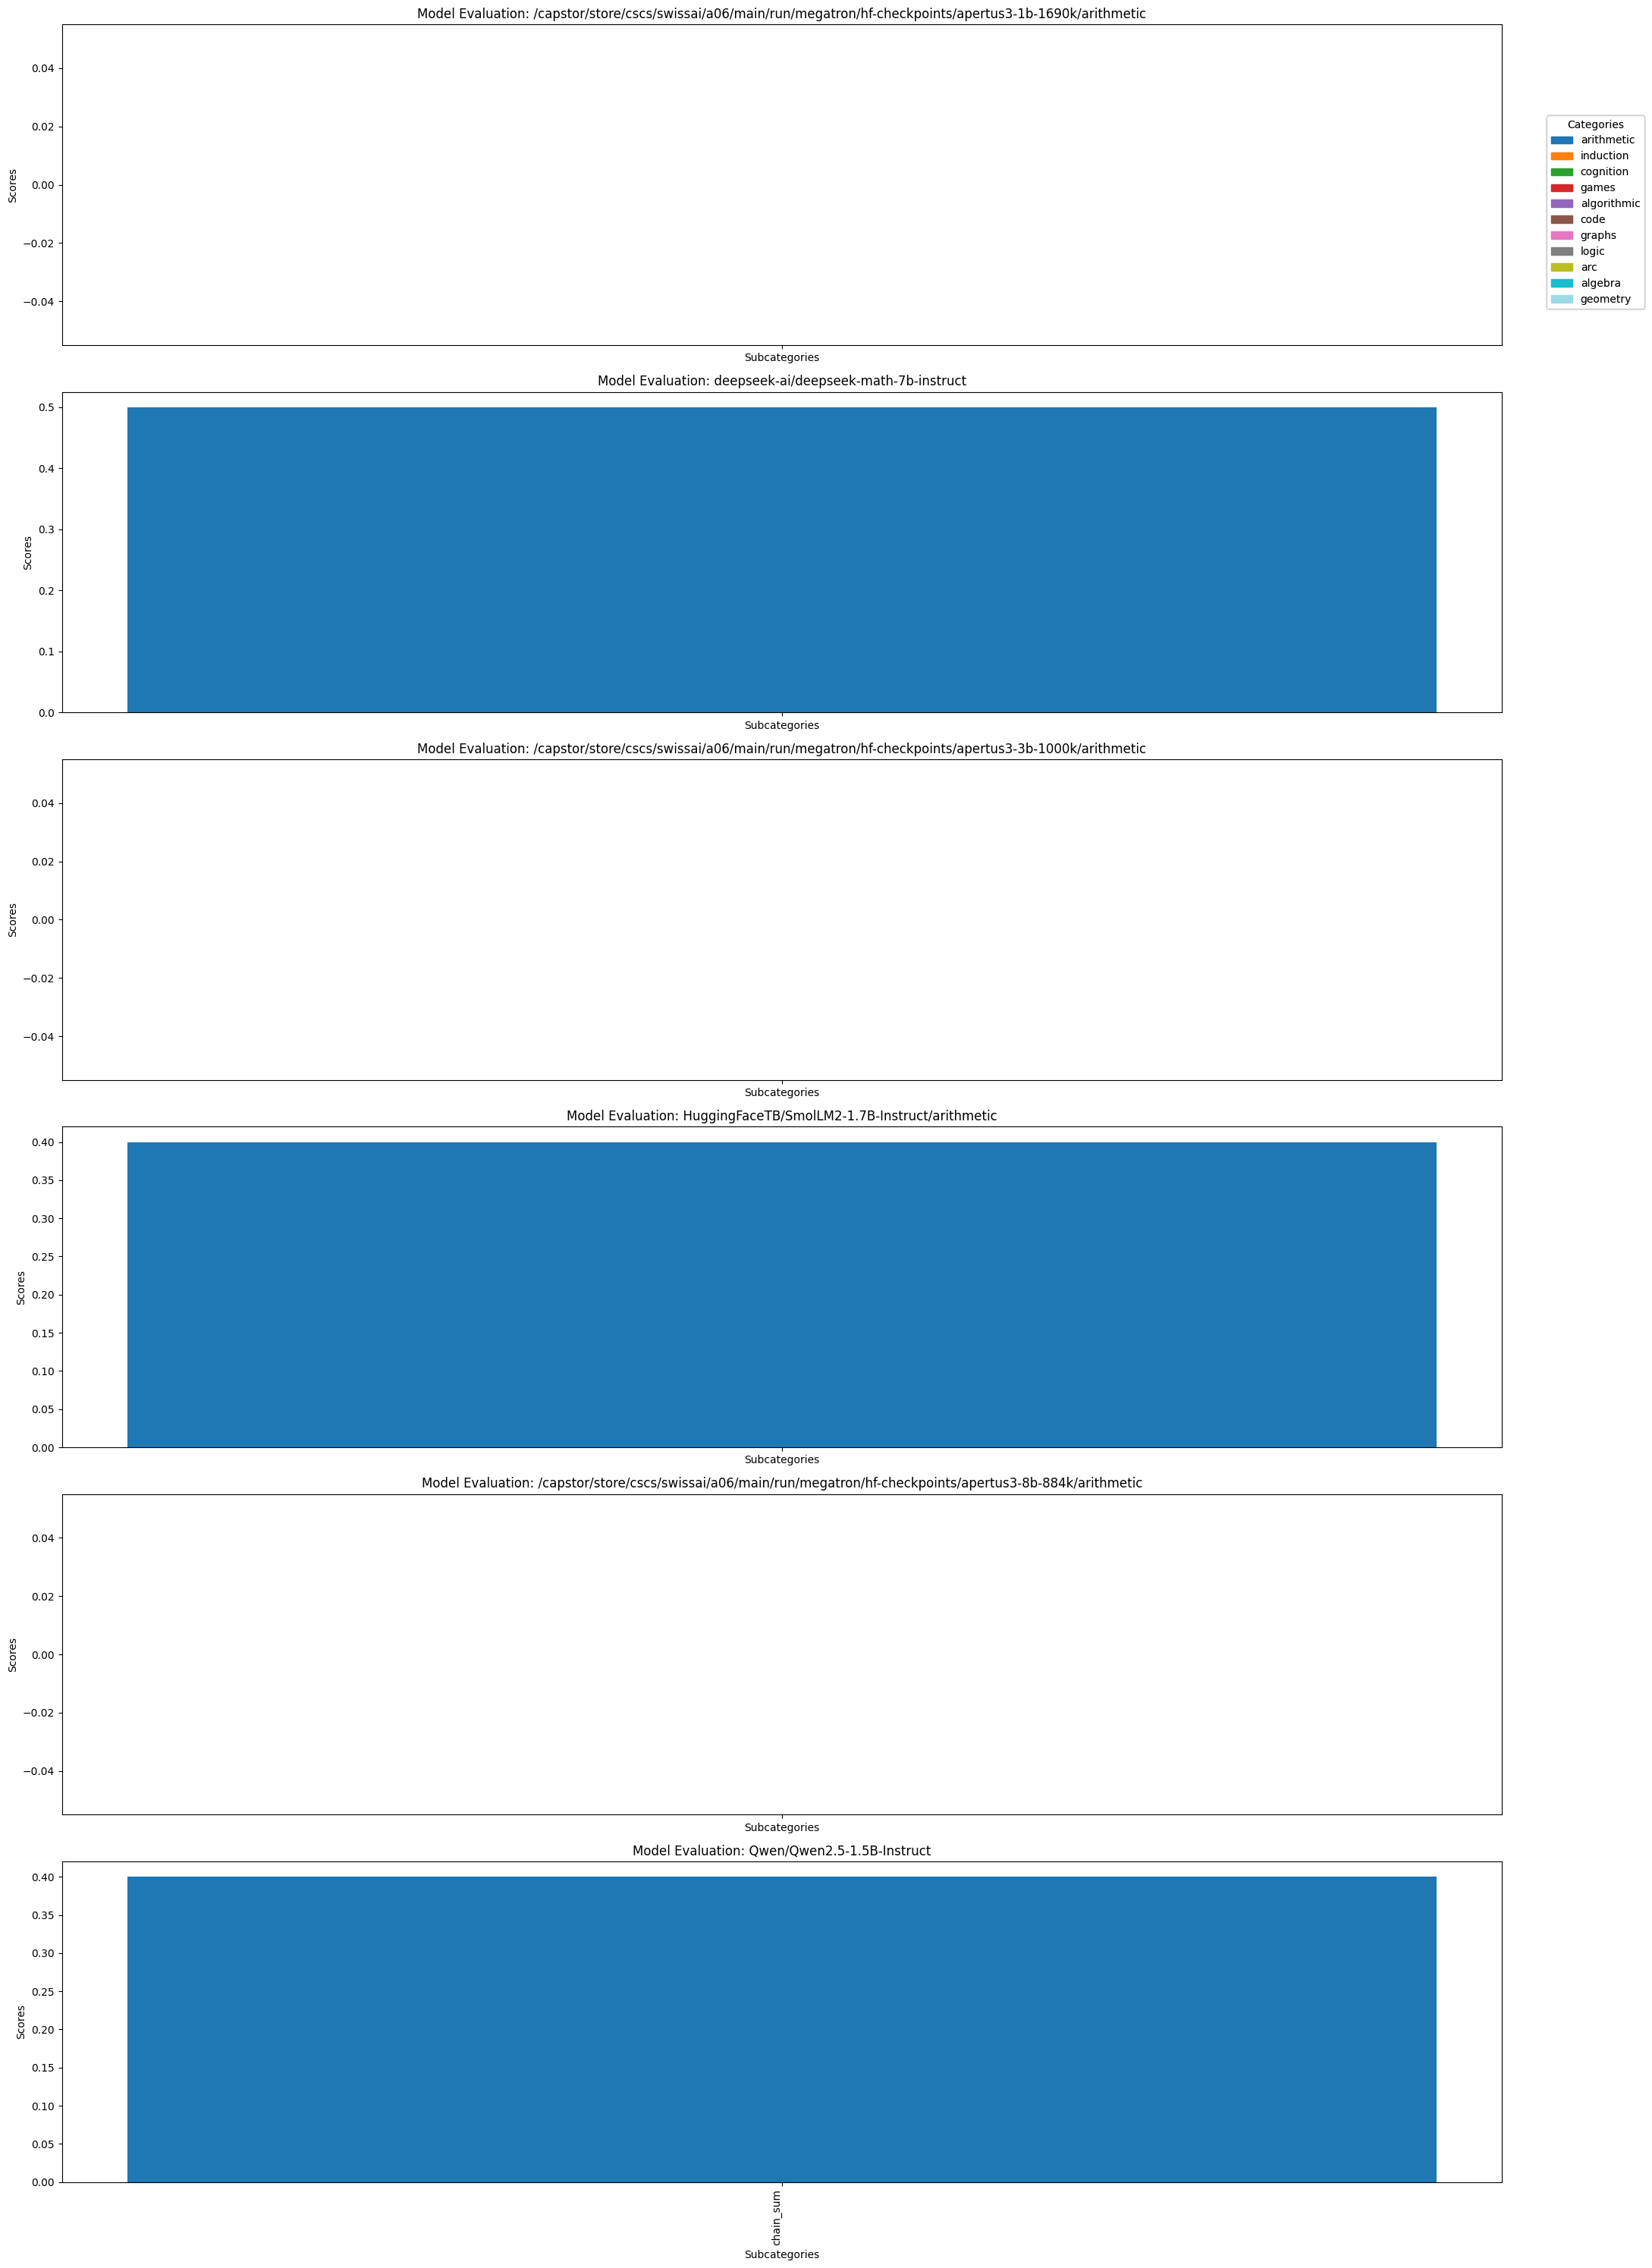

In [5]:
plot_model_subcategory_scores(summaries, categories)

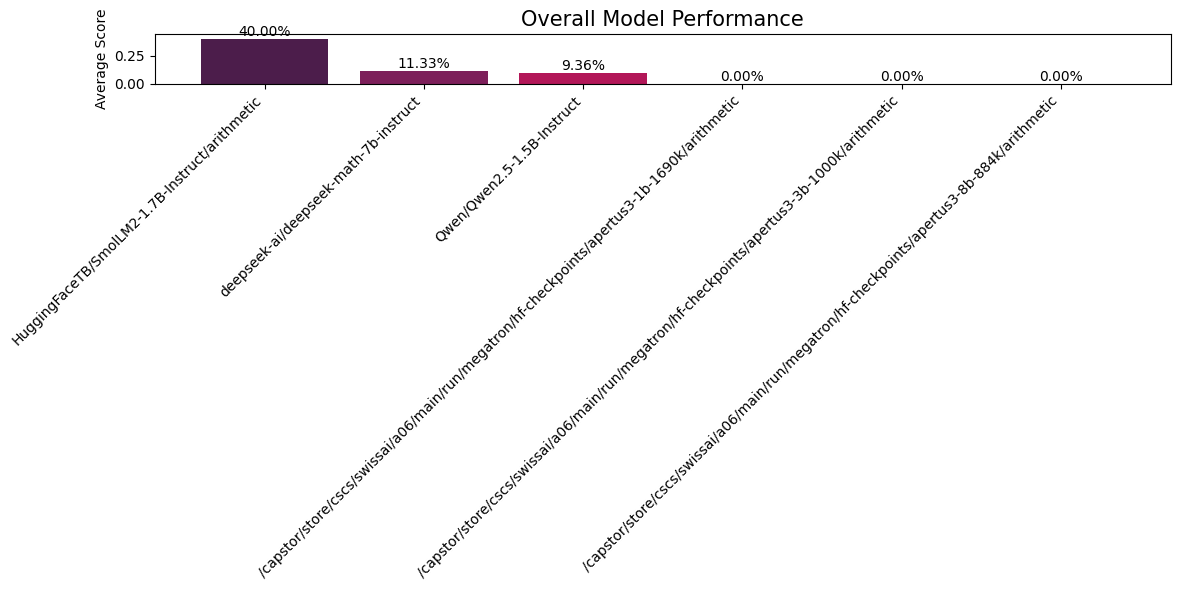

In [6]:
fig = create_overall_performance_bar(summaries)

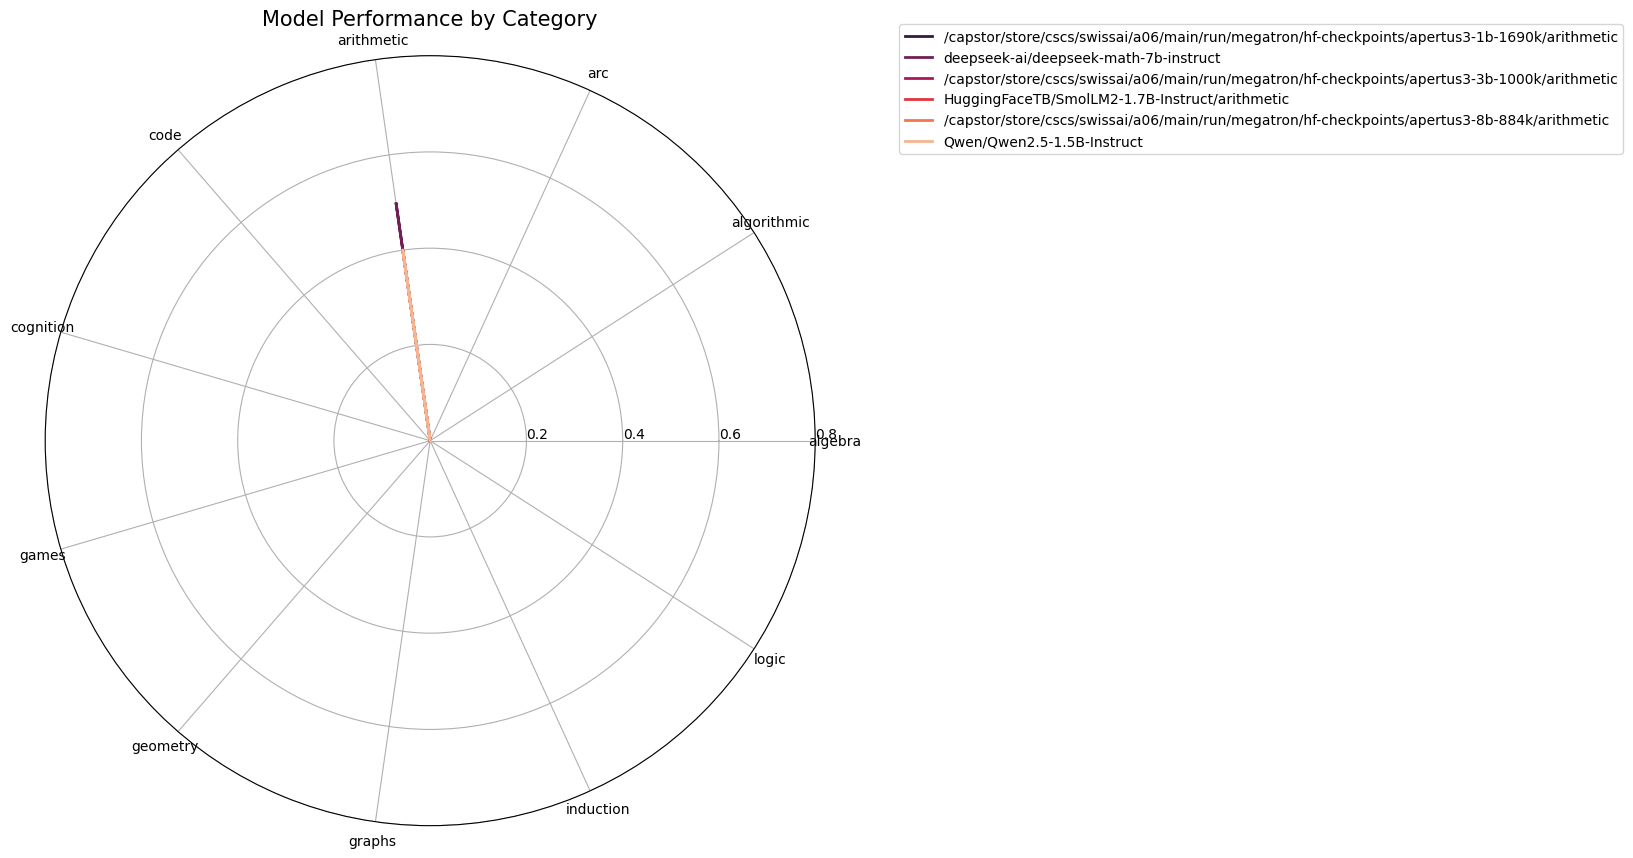

In [7]:

fig = create_category_radar(summaries, categories)


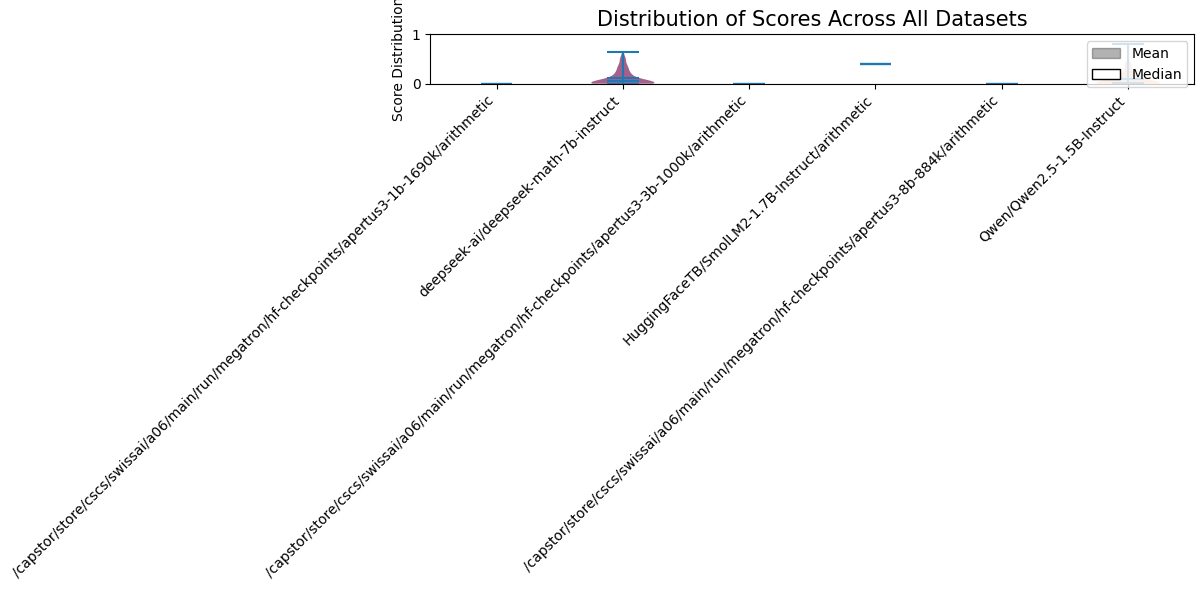

In [8]:
fig = create_performance_distribution_violin(summaries)

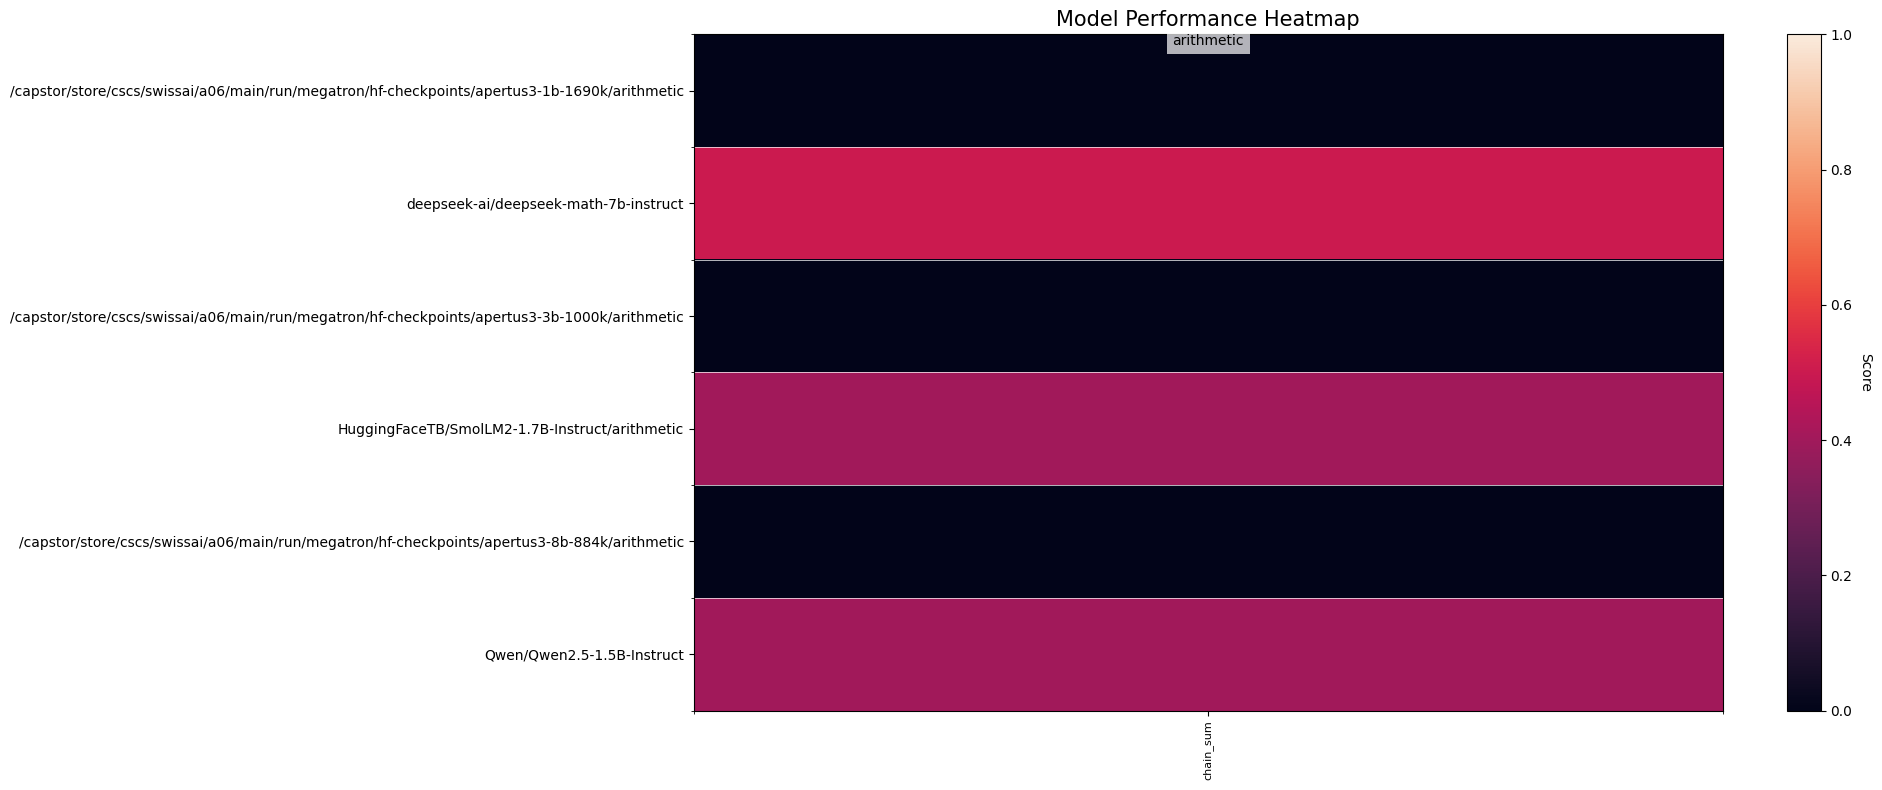

In [9]:
fig = create_performance_heatmap(summaries, categories)

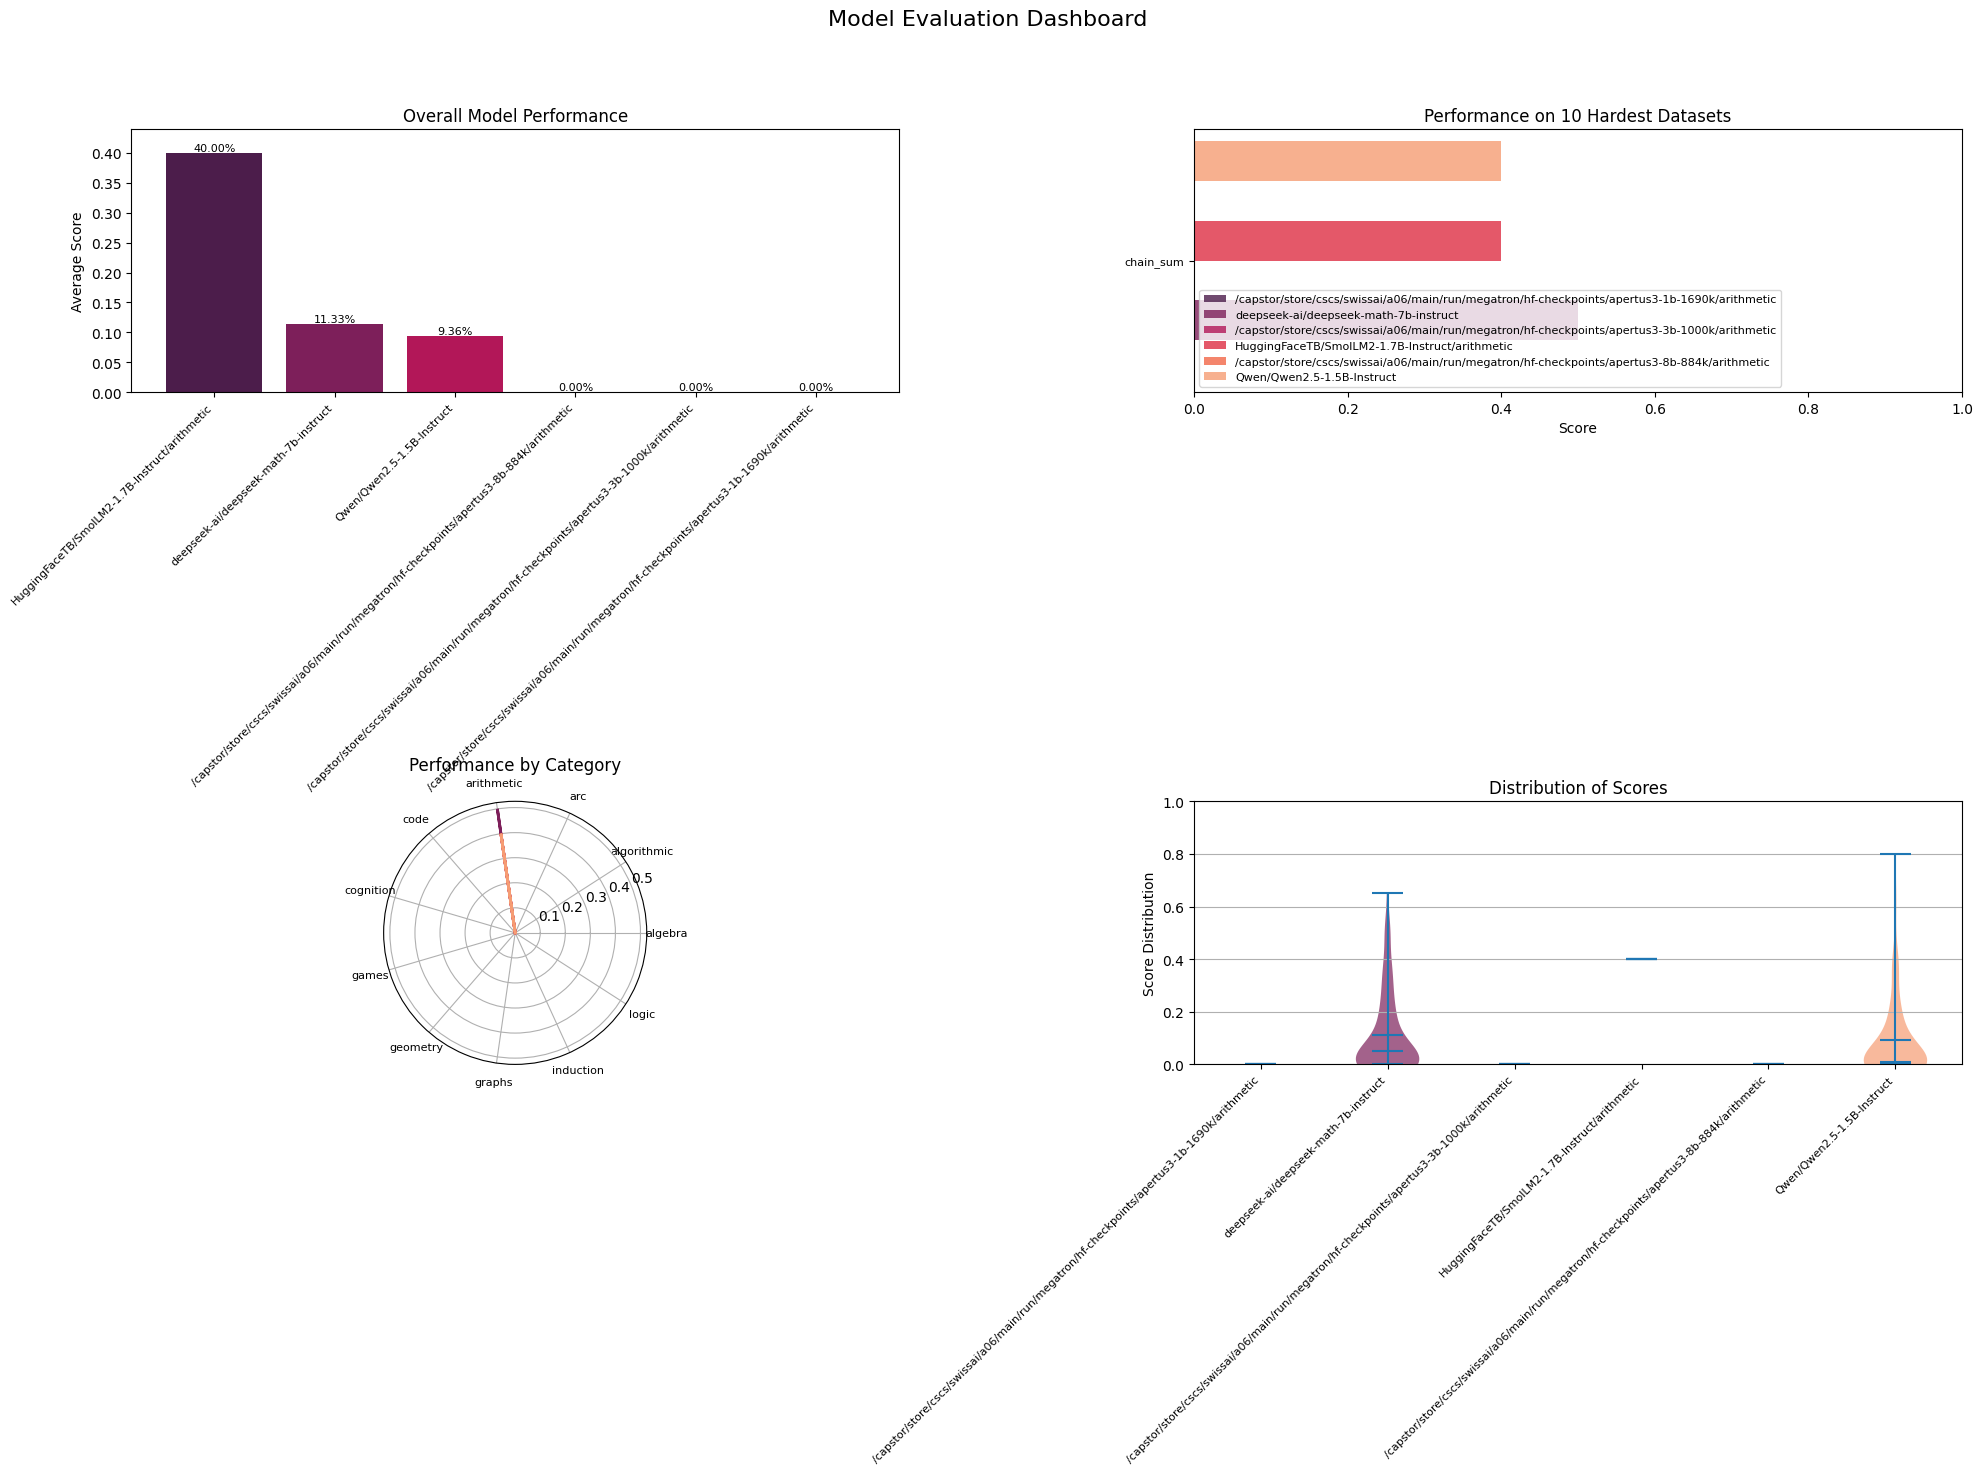

In [10]:
fig = create_dashboard(summaries, categories)

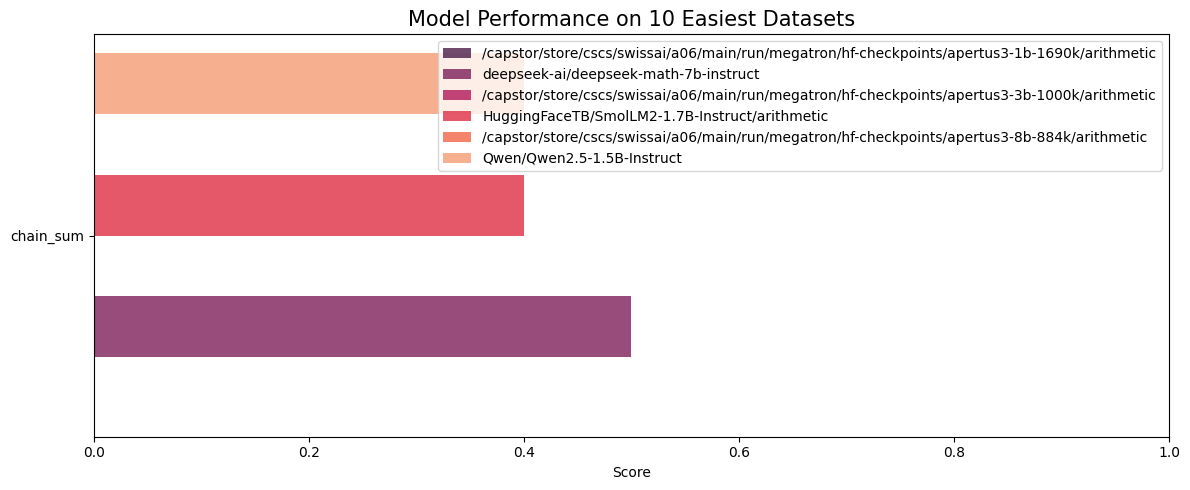

In [11]:
fig = create_top_datasets_comparison(summaries, 10, mode = "easiest")

In [12]:
import os
import json
from collections import defaultdict

def extract_full_model_responses(base_path):
    data_dict = defaultdict((lambda: defaultdict(dict)))
    
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".json") and not file.endswith("summary.json"):
                file_path = os.path.join(root, file)
                with open(file_path, "r", encoding="utf-8") as f:
                    try:
                        data = json.load(f)
                        category = data.get("category", "unknown")
                        name = data.get("name", "unknown")
                        if "results" in data:
                            for idx, result in enumerate(data["results"], 1):
                                answer_key = f"answer{idx}"
                                data_dict[category][name][answer_key] = result.get("full_model_response", "")
                    except json.JSONDecodeError:
                        print(f"Error decoding JSON in file: {file_path}")
    
    return data_dict


In [13]:
import numpy as np
def calculate_ttr(document_words):
    unique_words = set(document_words)
    ttr = len(unique_words) / len(document_words)
    return ttr

def compute_ttr(data_dict):
    """Compute TTR for each task in the extracted data."""
    ttr_dict = defaultdict(dict)  # Dictionary for TTR values
    
    for category, tasks in data_dict.items():
        for task, responses in tasks.items():
            all_words = []
            for answer_key, response in responses.items():
                all_words.append(calculate_ttr(response.split()))  # Collect words for TTR
            
            # Compute TTR for this task
            ttr_dict[category][task] = np.mean(all_words)
    
    return ttr_dict

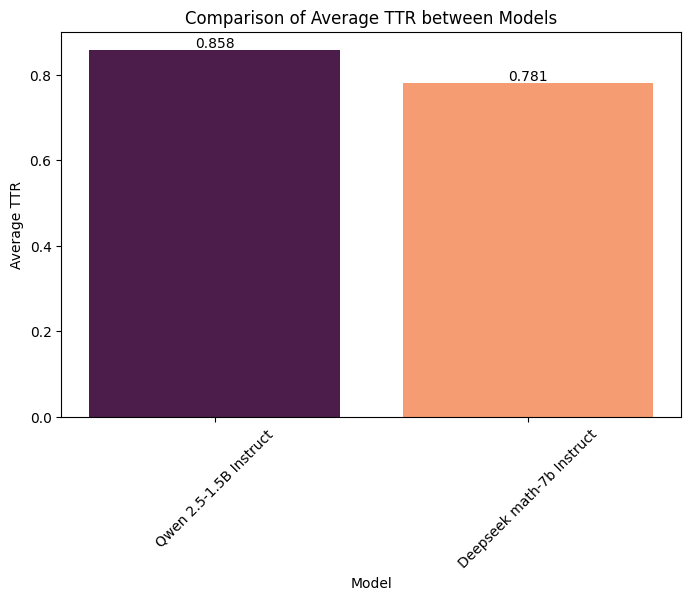

In [19]:
import matplotlib.pyplot as plt
def plot_ttr_comparison(ttr_values, title):
    """Plots a bar chart comparing average TTR values across models."""
    avg_ttr = {}
    
    for model, categories in ttr_values.items():
        total_ttr = 0
        count = 0
        for category in categories.values():
            for task_ttr in category.values():
                total_ttr += task_ttr
                count += 1
        avg_ttr[model] = total_ttr / count if count > 0 else 0
    colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0.2, 0.8, len(ttr_values)))
    plt.figure(figsize=(8, 5))
    bars = plt.bar(avg_ttr.keys(), avg_ttr.values(), color=colors)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.xlabel('Model')
    plt.ylabel('Average TTR')
    plt.title(title)
    plt.show()

base_path = "/capstor/scratch/cscs/camillechallier/reasoning-gym/eval/results/"
data1 = compute_ttr(extract_full_model_responses(base_path + "Qwen_Qwen2.5-1.5B-Instruct_20250325_181758"))
data2 = compute_ttr(extract_full_model_responses(base_path + "deepseek-ai_deepseek-math-7b-instruct_20250325_190802"))

data = {"Qwen 2.5-1.5B Instruct" : data1, "Deepseek math-7b Instruct" : data2}  # Merge results from both models

# Plot comparison
plot_ttr_comparison(data, title = "Comparison of Average TTR between Models")


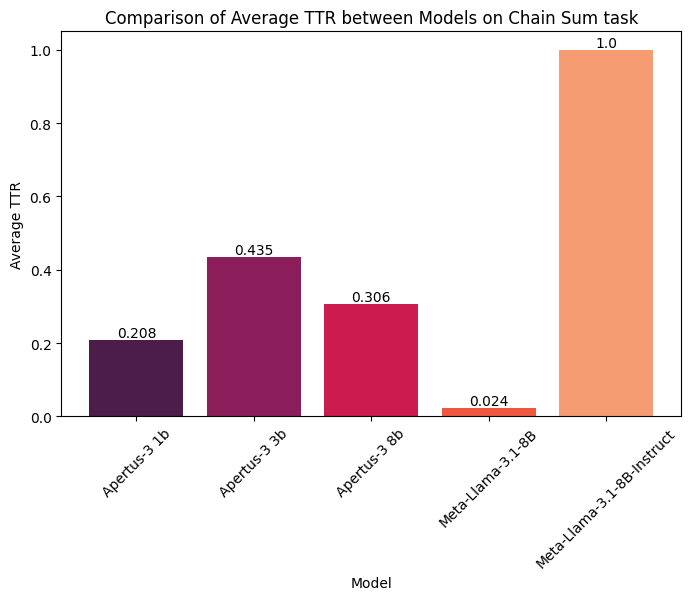

In [23]:
data1 = compute_ttr(extract_full_model_responses(base_path + "_capstor_store_cscs_swissai_a06_main_run_megatron_hf-checkpoints_apertus3-1b-1690k_arithmetic_20250404_173107"))
data2 = compute_ttr(extract_full_model_responses(base_path + "_capstor_store_cscs_swissai_a06_main_run_megatron_hf-checkpoints_apertus3-3b-1000k_arithmetic_20250404_172754"))
data3 = compute_ttr(extract_full_model_responses(base_path + "_capstor_store_cscs_swissai_a06_main_run_megatron_hf-checkpoints_apertus3-8b-884k_arithmetic_20250404_173414"))
data4 = compute_ttr(extract_full_model_responses(base_path + "_capstor_store_cscs_swissai_a06_models_Meta-Llama-3.1-8B_arithmetic_20250404_184227"))
data5 = compute_ttr(extract_full_model_responses(base_path + "_capstor_store_cscs_swissai_a06_models_Meta-Llama-3.1-8B-Instruct_arithmetic_20250404_175506"))

data = {"Apertus-3 1b" : data1, "Apertus-3 3b" : data2, "Apertus-3 8b" : data3, "Meta-Llama-3.1-8B" : data4, "Meta-Llama-3.1-8B-Instruct": data5}  # Merge results from both models

# Plot comparison
plot_ttr_comparison(data, title='Comparison of Average TTR between Models on Chain Sum task')